Confusion Matrix:
 [[1387  378]
 [ 323 1372]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1765
           1       0.78      0.81      0.80      1695

    accuracy                           0.80      3460
   macro avg       0.80      0.80      0.80      3460
weighted avg       0.80      0.80      0.80      3460



<ipython-input-7-575be8b08a98>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')


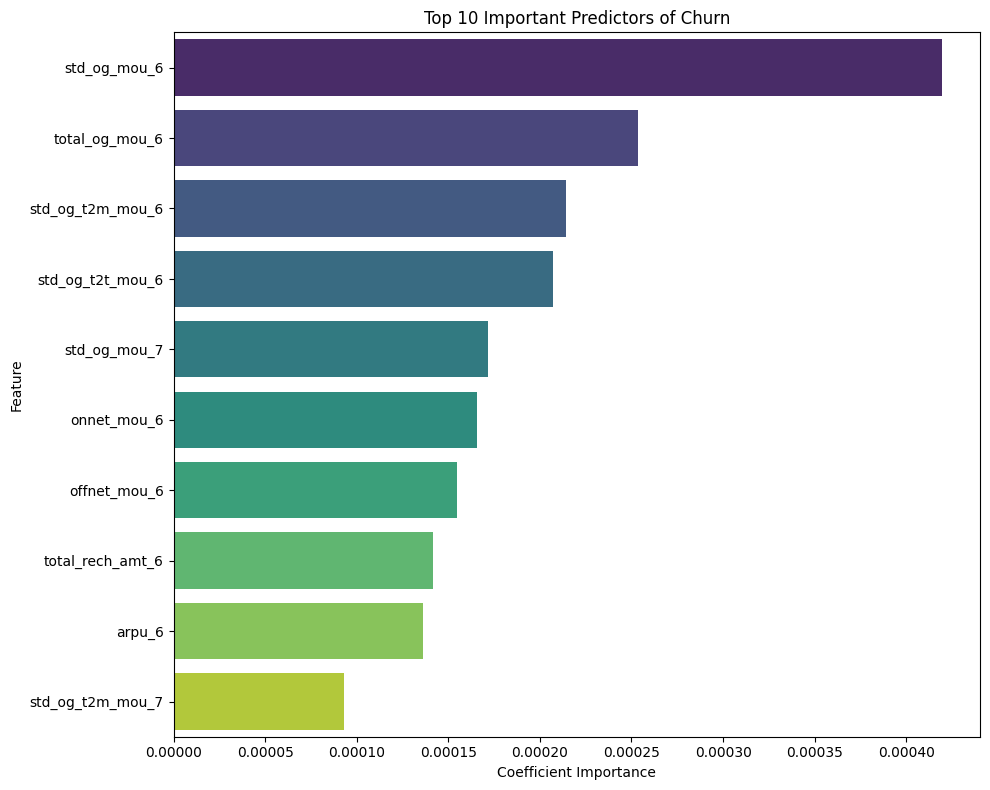

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/sample_data/telecom_churn_data.csv'
data = pd.read_csv(file_path)

# Step 1: Filter high-value customers
data['avg_recharge_good_phase'] = data[['arpu_6', 'arpu_7']].mean(axis=1)
recharge_70th_percentile = data['avg_recharge_good_phase'].quantile(0.7)
high_value_customers = data[data['avg_recharge_good_phase'] >= recharge_70th_percentile].copy()  # Explicit copy

# Step 2: Tag churners
churn_conditions = (
    (high_value_customers['total_ic_mou_9'] == 0) &
    (high_value_customers['total_og_mou_9'] == 0) &
    (high_value_customers['vol_2g_mb_9'] == 0) &
    (high_value_customers['vol_3g_mb_9'] == 0)
)
high_value_customers.loc[:, 'churn'] = churn_conditions.astype(int)  # Use .loc for assignment

# Step 3: Remove churn-phase columns
churn_phase_columns = [col for col in high_value_customers.columns if col.endswith('_9')]
data_prepared = high_value_customers.drop(columns=churn_phase_columns)

# Step 4: Prepare data for modeling
# Separate features and target
X = data_prepared.drop(columns=['churn', 'mobile_number'])  # Drop irrelevant columns
y = data_prepared['churn']

# Step 4.1: Handle non-numeric data
# Identify date columns and convert to numeric
date_cols = X.columns[X.dtypes == 'object']  # Assuming date columns are of type object
for col in date_cols:
    try:
        X[col] = pd.to_datetime(X[col], errors='coerce').astype(int) / 10**9  # Convert to Unix timestamp
    except ValueError:
        X[col] = pd.to_numeric(X[col], errors='coerce')  # Handle numeric strings

# Encode remaining non-numeric columns (if any)
non_numeric_cols = X.select_dtypes(include='object').columns
X[non_numeric_cols] = X[non_numeric_cols].fillna('Missing')  # Fill missing with a placeholder
X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)  # One-hot encoding

# Step 4.2: Handle missing values in numeric columns
X.fillna(X.mean(), inplace=True)

# Step 4.3: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Step 5: Train logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = logreg.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify important predictors
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': logreg.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Step 7: Visualize important predictors
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Important Predictors of Churn')
plt.xlabel('Coefficient Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
